In [1]:
import nltk
import numpy as np
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics

import warnings; warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# nltk.download_gui()

In [3]:
sms = pd.read_csv('./datasets/spam_sms.csv', sep='\t', names=['label', 'message'])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

### Feature Engineering

In [6]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


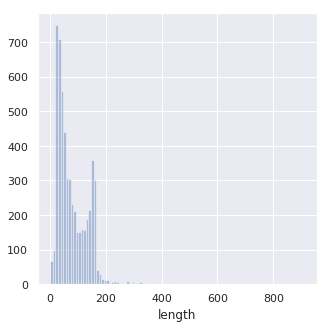

In [7]:
plt.figure(figsize=(5, 5))
sns.distplot(sms['length'], bins=100, kde=False)

In [8]:
sms['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [9]:
sms[sms['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa747a10208>,
      dtype=object)

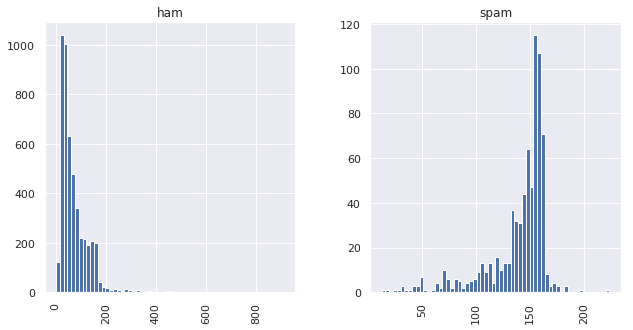

In [10]:
sms.hist(column='length', by='label', bins=60, figsize=(10, 5))

The figures show that the 'spam' messages contain more words.

In [11]:
def lower_case(text):
    return text.lower()

def remove_punctuation(text):
    
    no_punc = [c for c in text if c not in string.punctuation]
    no_punc = ''.join(no_punc)
    
    return no_punc

def remove_stop_words(text):
    
    text = [word for word in text.split() if word not in stopwords.words('english')]
    text = ' '.join(text)
    
    return text

def tokenize(text):
    
    return text.split()

def remove_short_words(in_words, length=2):
    
    out_words = [word for word in in_words if len(word) >= length]
    return out_words

def preprocess_text(text):
    
    return remove_short_words(tokenize(remove_stop_words(remove_punctuation(lower_case(text)))))

**NB.** The `stopwords.words('english')` function gives us the stop words in English.

In [12]:
print(preprocess_text(sms['message'].loc[0]))

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'got', 'amore', 'wat']


In [13]:
sms['message'].head(5).apply(preprocess_text)

0    [go, jurong, point, crazy, available, bugis, g...
1                          [ok, lar, joking, wif, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3                 [dun, say, early, hor, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Vectorization

#### TF Transformer

The `CountVectorizer` class lets us have TF or Bag of Words vectorization.

In [14]:
tf_transformer = CountVectorizer(analyzer=preprocess_text).fit(sms['message'])

The `vocabulary_` attribute is a dictionary which holds a word with its index.

In [15]:
print('There are {} words.'.format(len(tf_transformer.vocabulary_)))
print('The index of "say" is {} in the dictionary.'.format(tf_transformer.vocabulary_['say']))

There are 9478 words.
The index of "say" is 7171 in the dictionary.


In [16]:
sms_4 = sms['message'][3]
print(sms_4)

U dun say so early hor... U c already then say...


In [17]:
tf_4 = tf_transformer.transform([sms_4])
print(tf_4)

  (0, 1119)	1
  (0, 2984)	1
  (0, 3004)	1
  (0, 4195)	1
  (0, 7171)	2


In [18]:
print(tf_4.shape)

(1, 9478)


In [19]:
tf_transformer.get_feature_names()[7185]

'scenario'

In [20]:
sms_tf = tf_transformer.transform(sms['message'])

In [21]:
print('Shape of Sparse Matrix is {}.'.format(sms_tf.shape))

Shape of Sparse Matrix is (5572, 9478).


In [22]:
sparsity_rate = (100.0 * sms_tf.nnz / (sms_tf.shape[0] * sms_tf.shape[1]))
print('Sparsity rate is %.2f.' % (1 - sparsity_rate))

Sparsity rate is 0.91.


#### TF-IDF Transformer

The `TFidfTransformer` class lets us have TF-IDF vectorization.

In [23]:
tf_idf_transformer = TfidfTransformer().fit(sms_tf)

In [24]:
tf_idf_4  = tf_idf_transformer.transform(tf_4)
print(tf_idf_4)

  (0, 7171)	0.619775084625881
  (0, 4195)	0.5143873498708452
  (0, 3004)	0.37159298853883077
  (0, 2984)	0.3423052157911949
  (0, 1119)	0.3098875423129405


In [25]:
print(tf_idf_transformer.idf_[tf_transformer.vocabulary_['university']])

8.239394426449646


In [26]:
sms_tf_idf = tf_idf_transformer.transform(sms_tf)

In [27]:
print(sms_tf_idf.shape)
print()
print(sms_tf_idf[0])
print(sms_tf_idf[0].shape)
print(type(sms_tf_idf[0]))

(5572, 9478)

  (0, 9165)	0.23823945205277955
  (0, 8927)	0.19697793561986873
  (0, 6410)	0.27021168527978756
  (0, 4825)	0.2918551233339086
  (0, 4665)	0.3454707946150376
  (0, 3862)	0.19228423996761165
  (0, 3822)	0.16212654355140843
  (0, 3765)	0.15677261126284098
  (0, 2470)	0.2675433493028618
  (0, 2186)	0.2918551233339086
  (0, 1849)	0.2918551233339086
  (0, 1847)	0.32978921603981126
  (0, 1379)	0.26270259822044817
  (0, 1146)	0.3454707946150376
(1, 9478)
<class 'scipy.sparse.csr.csr_matrix'>


### Classification

In [28]:
sms.head(5)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [29]:
X_train, X_test, y_train, y_test = train_test_split(sms['message'], sms['label'], 
                                                    test_size=0.3, random_state=110)

Now you should do the vectorization on the train dataset, then apply it on both of the train and test datasets. Instead, you can apply the 'pipline' solution.

In [30]:
pipline = Pipeline([('tf', CountVectorizer(analyzer=preprocess_text)), 
                    ('tfidf', TfidfTransformer()), 
                    ('classifier', MultinomialNB())])

In [31]:
pipline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tf', CountVectorizer(analyzer=<function preprocess_text at 0x7fa747a11d90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [32]:
y_pred = pipline.predict(X_test)

In [33]:
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: %.2f' % metrics.accuracy_score(y_test, y_pred))
print('F1-Score: %.2f' % metrics.f1_score(y_test, y_pred, pos_label='spam'))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1450
        spam       1.00      0.73      0.84       222

   micro avg       0.96      0.96      0.96      1672
   macro avg       0.98      0.86      0.91      1672
weighted avg       0.97      0.96      0.96      1672

Accuracy: 0.96
F1-Score: 0.84
